<a href="https://colab.research.google.com/github/Cjeyms/CCMACLRL_EXERCISES_COM222ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [106]:
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [107]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [108]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [109]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [110]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [111]:
# put your answer here
data = df_train.head(10)
print(data)

                                                text  label
0  Presidential candidate Mar Roxas implies that ...      1
1  Parang may mali na sumunod ang patalastas ng N...      1
2                    Bet ko. Pula Ang Kulay Ng Posas      1
3                               [USERNAME] kakampink      0
4  Bakit parang tahimik ang mga PINK about Doc Wi...      1
5  "Ang sinungaling sa umpisa ay sinungaling hang...      1
6                                          Leni Kiko      0
7  Nahiya si Binay sa Makati kaya dito na lang sa...      1
8                            Another reminderHalalan      0
9  [USERNAME] Maybe because VP Leni Sen Kiko and ...      0


2. Check how many rows and columns are in the training dataset using `.info()`

In [112]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [113]:
# put your answer here
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [114]:
# put your answer here
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [115]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [116]:
# put your answer here
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

7. Remove rows with NaN values

In [117]:
# put your answer here
df_train.dropna(inplace=True)
df_train.isnull().sum()

,0
text,0
label,0


8. Convert all text to lowercase

In [118]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1


9. Remove digits, URLS and special characters

In [119]:
# put your answer here
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

10. Remove stop words

In [120]:
# put your answer here
# Extended list of Tagalog stop words
tagalog_stop_words = [
    "ako", "ako'y", "alam", "at", "dahil", "habang", "ito", "iyan",
    "iyon", "ka", "kailangan", "kasama", "mga", "mas", "na", "ng",
    "ngunit", "o", "sa", "saan", "sino", "tayo", "tungkol", "upang", "wala",
    "ang", "anong", "bawat", "bago", "bakit", "dati", "dito", "ganito",
    "ganoon", "hindi", "iba", "ilalim", "isinasaalang-alang", "iyong",
    "kahit", "kaya", "kung", "maging", "muli", "narito", "ngayon",
    "pagkatapos", "paano", "pati", "tulad", "yung"
]
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tagalog_stop_words)]))
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali sumunod patalastas nescaf coff...,1
2,bet ko. pula kulay posas,1
3,[username] kakampink,0
4,parang tahimik pink about doc willie ong? no r...,1


11. Use Stemming or Lemmatization

In [121]:
# put your answer here
lemmatizer = WordNetLemmatizer()
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali sumunod patalastas nescaf coff...,1
2,bet ko. pula kulay posas,1
3,[username] kakampink,0
4,parang tahimik pink about doc willie ong? no r...,1


## C. Training your model

12. Put all text training data in variable **X_train**

In [122]:
# put your answer here
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [123]:
# put your answer here
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [124]:
# put your answer here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of MultinomalNB()

In [125]:
# put your answer here
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=0.1)

16. Train the model using `.fit()`

In [126]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.1)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [127]:
# put your answer here
X_validation = df_validation['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [128]:
# put your answer here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy (Validation): {accuracy}")
print(f"Precision (Validation): {precision}")
print(f"Recall (Validation): {recall}")
print(f"F1 Score (Validation): {f1}")

Accuracy (Validation): 0.8164285714285714
Precision (Validation): 0.7817385866166354
Recall (Validation): 0.8833922261484098
F1 Score (Validation): 0.8294625082946251


19. Create a confusion matrix using the **validation dataset**

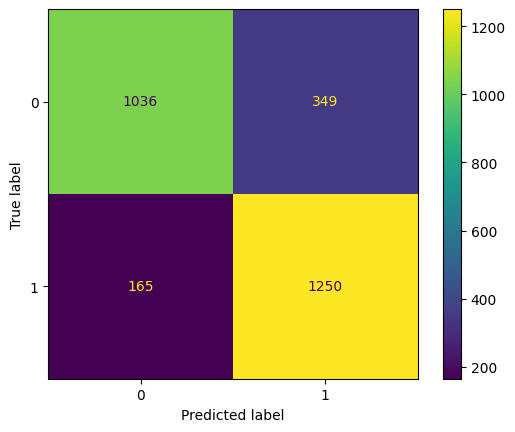

In [129]:
# put your answer here
cm = confusion_matrix(y_validation, y_validation_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [130]:
# put your answer here
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [131]:
# put your answer here

y_test = df_test['label']
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Accuracy (Test): {accuracy_test}")
print(f"Precision (Test): {precision_test}")
print(f"Recall (Test): {recall_test}")
print(f"F1 Score (Test): {f1_test}")

Accuracy (Test): 0.8163701067615659
Precision (Test): 0.7777078085642317
Recall (Test): 0.8834048640915594
F1 Score (Test): 0.8271935699933021


22. Create a confusion matrix using the **test dataset**

In [132]:
# put your answer here
confusion_matrix(y_test, y_test_pred)

array([[1059,  353],
       [ 163, 1235]])

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [133]:
new_input = ["Napakasaya namin sa mahal kong sinilangan, ang tahanan ng aking lahi, kinukupkop ako at tinutulungan upang maging malakas, masipag, at marangal"]
new_input_transformed = vectorizer.transform(new_input)
prediction = model.predict(new_input_transformed)
print("Prediction:", prediction)

Prediction: [0]


24. Test the model by providing a hate speech input. The model should predict it as 1

In [134]:
new_input = ["Ang init ng ulo ko ang gulo ng paligid ang sarap talaga sumigaw ng putang ina"]
new_input_transformed = vectorizer.transform(new_input)
prediction = model.predict(new_input_transformed)
print("Prediction:", prediction)

Prediction: [1]
